## Projet PACTE 4A-IIIA: Data Science Formula 1 World  Championship
### Sujet: L'impact de la position de depart sur le resultat d'une course.

Dans cette étude, nous nous intéressons à l’impact de la position de départ sur le résultat d’une course de Formule 1, en adoptant une approche basée sur l’analyse descriptive des données. L’objectif est de comprendre comment la position de départ influence les performances des pilotes, tout en explorant des facteurs connexes tels que les classements cumulés et les performances individuelles.

Pour cette analyse, nous utilisons plusieurs fichiers issus de la base de données Formula 1, chacun apportant des informations complémentaires :  

- **`lap_times.csv`** : Contient les temps au tour pour chaque pilote, permettant d’examiner la régularité et la performance au cours de la course.  
- **`qualifying.csv`** : Fournit les résultats des qualifications, y compris les temps enregistrés dans chaque session, et aide à relier les positions de départ aux performances en course.  
- **`races.csv`** : Offre des informations contextuelles sur chaque Grand Prix, telles que l’année, le lieu, et le circuit.  
- **`results.csv`** : Détaille les résultats spécifiques de chaque course, comme la position finale, les points marqués et les incidents de course.  
- **`status.csv`** : Indique les raisons de l’abandon ou de l’échec pour certains pilotes, utile pour analyser les événements qui perturbent les performances.  
- **`driver_standings.csv`** : Résume le classement global des pilotes après chaque course, incluant les points accumulés et les victoires totales. Ce fichier nous permet d’intégrer une perspective cumulative pour évaluer l’impact des résultats individuels sur le championnat.  

Les variables pertinentes que nous analyserons incluent :  
1. **`grid`** (fichier `results.csv`) : Position de départ sur la grille, essentielle pour comprendre son influence sur les performances en course.  
2. **`positionOrder`** (fichier `results.csv`) : Position finale à l’arrivée, pour évaluer les progrès ou les déclins des pilotes pendant la course.  
3. **`points`** (fichier `driver_standings.csv`) : Points cumulés par pilote, pour relier les performances individuelles à l’évolution globale du championnat.  
4. **`milliseconds`** (fichier `lap_times.csv`) : Temps au tour en millisecondes, pour analyser la constance des pilotes et détecter les variations de performance.  
5. **`q3`** (fichier `qualifying.csv`) : Temps réalisé lors de la troisième session de qualification, clé pour déterminer la position de départ.  
En analysant ces variables, nous espérons identifier des tendances et corrélations qui éclairent le rôle des qualifications, des performances en course, et des incidents dans les résultats finaux.  

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#### 1. Chargement des données

In [8]:
lap_times = pd.read_csv("./dataset/lap_times.csv")
qualifying = pd.read_csv("./dataset/qualifying.csv") 
races = pd.read_csv("./dataset/races.csv")
results = pd.read_csv("./dataset/results.csv")
status = pd.read_csv("./dataset/status.csv")
driver_standings = pd.read_csv("./dataset/driver_standings.csv")

##### Verification de chargement

In [9]:
# Vérification des datasets importés
datasets = {
    "lap_times": lap_times,
    "qualifying": qualifying,
    "races": races,
    "results": results,
    "status": status,
    "driver_standings": driver_standings
}

for name, df in datasets.items():
    print(f"{name}: {df.shape[0]} lignes, {df.shape[1]} colonnes")

lap_times: 575029 lignes, 6 colonnes
qualifying: 10254 lignes, 9 colonnes
races: 1125 lignes, 18 colonnes
results: 26519 lignes, 18 colonnes
status: 139 lignes, 2 colonnes
driver_standings: 34595 lignes, 7 colonnes


#### 2. Préparation des données

#### 2.1. Exploration initiale des données
Cette étape permet d’avoir une vue d’ensemble des datasets (colonnes, types de données, valeurs manquantes).

In [10]:
lap_times.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [11]:
qualifying.head(15)

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
5,6,18,15,7,11,6,1:26.427,1:26.101,1:28.527
6,7,18,3,3,7,7,1:26.295,1:26.059,1:28.687
7,8,18,14,9,9,8,1:26.381,1:26.063,1:29.041
8,9,18,10,7,12,9,1:26.919,1:26.164,1:29.593
9,10,18,20,5,15,10,1:26.702,1:25.842,\N


Convertion des variables temporelles q1, q2, q3 en secondes

In [12]:
def convert_time_to_seconds(time_str):
    """
    Convertit une chaîne de temps 'mm:ss.SSS' en secondes.
    Ignore les valeurs manquantes.
    """
    if not str(time_str) or str(time_str) == "\\N":  # Vérifie si la valeur est manquante
        return None  # Retourne vide si la valeur est manquante
    try:
        # Divise la chaîne en minutes et secondes
        minutes, seconds = str(time_str).split(':')
        # Convertit la partie minutes en entier et la partie secondes en flottant
        total_seconds = int(minutes) * 60 + float(seconds)
        return total_seconds
    except ValueError:
        # Gestion des erreurs au cas où la chaîne est mal formatée
        return None
    
# Conversion des colonnes de temps
time_columns = ['q1', 'q2', 'q3']
for col in time_columns:
    qualifying[col + "new"] = [convert_time_to_seconds(t) for t in qualifying[col]]
    

In [13]:
qualifying.head(20)

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3,q1new,q2new,q3new
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714,86.572,85.187,86.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869,86.103,85.315,86.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079,85.664,85.452,87.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178,85.994,85.691,87.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236,85.960,85.518,87.236
5,6,18,15,7,11,6,1:26.427,1:26.101,1:28.527,86.427,86.101,88.527
6,7,18,3,3,7,7,1:26.295,1:26.059,1:28.687,86.295,86.059,88.687
7,8,18,14,9,9,8,1:26.381,1:26.063,1:29.041,86.381,86.063,89.041
8,9,18,10,7,12,9,1:26.919,1:26.164,1:29.593,86.919,86.164,89.593
9,10,18,20,5,15,10,1:26.702,1:25.842,\N,86.702,85.842,NaN


In [14]:
races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [15]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [16]:
status.head()

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [17]:
driver_standings.head()

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


In [18]:
# Afficher les premières lignes et résumés des datasets
for name, df in datasets.items():
    print(f"Dataset: {name}")
    print(df.info())


Dataset: lap_times
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575029 entries, 0 to 575028
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        575029 non-null  int64 
 1   driverId      575029 non-null  int64 
 2   lap           575029 non-null  int64 
 3   position      575029 non-null  int64 
 4   time          575029 non-null  object
 5   milliseconds  575029 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 26.3+ MB
None
Dataset: qualifying
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10254 entries, 0 to 10253
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   qualifyId      10254 non-null  int64  
 1   raceId         10254 non-null  int64  
 2   driverId       10254 non-null  int64  
 3   constructorId  10254 non-null  int64  
 4   number         10254 non-null  int64  
 5   position       10254 non-null

##### 2.2. Traitement des valeurs manquantes
Les valeurs manquantes peuvent fausser les résultats. On identifie ces valeurs et choisit une stratégie : suppression, imputation, ou autre.

In [19]:
# Vérification des valeurs manquantes
for name, df in datasets.items():
    print(f"{name} - Valeurs manquantes:\n{df.isnull().sum()}\n")

lap_times - Valeurs manquantes:
raceId          0
driverId        0
lap             0
position        0
time            0
milliseconds    0
dtype: int64

qualifying - Valeurs manquantes:
qualifyId           0
raceId              0
driverId            0
constructorId       0
number              0
position            0
q1                  0
q2                 13
q3                 27
q1new             154
q2new            4585
q3new            6740
dtype: int64

races - Valeurs manquantes:
raceId         0
year           0
round          0
circuitId      0
name           0
date           0
time           0
url            0
fp1_date       0
fp1_time       0
fp2_date       0
fp2_time       0
fp3_date       0
fp3_time       0
quali_date     0
quali_time     0
sprint_date    0
sprint_time    0
dtype: int64

results - Valeurs manquantes:
resultId           0
raceId             0
driverId           0
constructorId      0
number             0
grid               0
position           0
positionTe

##### 2.3. Correction des valeurs maquantes

+ qualifying.csv

In [20]:
qualifying['q1new'] = qualifying['q1new'].fillna(qualifying['q1new'].mean())
qualifying['q2new'] = qualifying['q2new'].fillna(qualifying['q2new'].mean())
qualifying['q3new'] = qualifying['q3new'].fillna(qualifying['q3new'].mean())

In [21]:
qualifying.head(20)

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3,q1new,q2new,q3new
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714,86.572,85.187000,86.714000
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869,86.103,85.315000,86.869000
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079,85.664,85.452000,87.079000
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178,85.994,85.691000,87.178000
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236,85.960,85.518000,87.236000
5,6,18,15,7,11,6,1:26.427,1:26.101,1:28.527,86.427,86.101000,88.527000
6,7,18,3,3,7,7,1:26.295,1:26.059,1:28.687,86.295,86.059000,88.687000
7,8,18,14,9,9,8,1:26.381,1:26.063,1:29.041,86.381,86.063000,89.041000
8,9,18,10,7,12,9,1:26.919,1:26.164,1:29.593,86.919,86.164000,89.593000
9,10,18,20,5,15,10,1:26.702,1:25.842,\N,86.702,85.842000,87.415273


#### 3. Analyse descriptive des données

##### 3.1. Statistiques descriptives
Fournir des statistiques (moyenne, médiane, écart-type, etc.) pour comprendre la distribution des variables.

+ **`q3`** (fichier `qualifying.csv`) : Temps réalisé lors de la troisième session de qualification, clé pour déterminer la position de départ.  
On va utiliser la nouvelle variable `q3new` à cet effet

In [22]:
moy_q3 = qualifying['q3new'].mean()
print(moy_q3)

87.41527319294254


In [23]:
median_q3 = qualifying['q3new'].median()
print(median_q3)

87.41527319294252


In [24]:
ecart_type_q3 = qualifying['q3new'].std()
print(ecart_type_q3)

7.180494507908724


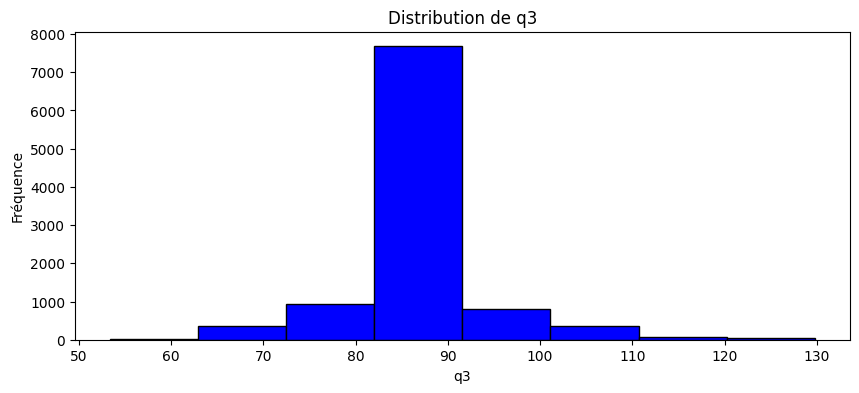

In [25]:
plt.figure(figsize=(10, 4))
plt.hist(qualifying['q3new'], bins=8, color='blue', edgecolor = 'black')
plt.title('Distribution de q3')
plt.xlabel('q3')
plt.ylabel('Fréquence')
plt.show()

+ **`grid`** (fichier `results.csv`) : Position de départ sur la grille, essentielle pour comprendre son influence sur les performances en course.  

In [26]:
results_races = pd.merge(results, races, on="raceId", how="inner")

In [27]:
pd.set_option('display.max_columns', None)
results_races.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time_x,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,name,date,time_y,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


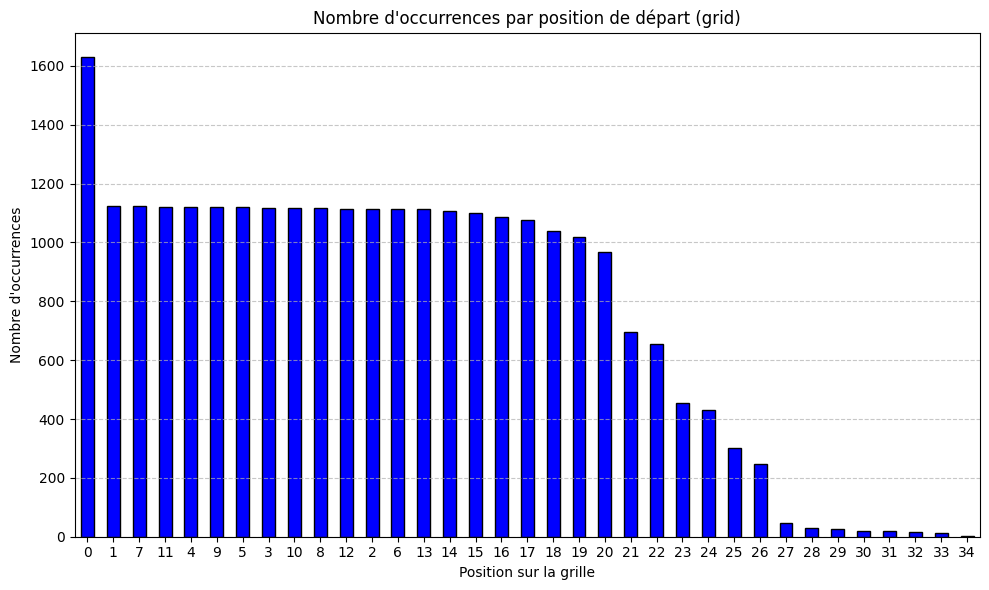

In [28]:
# Convertir la variable 'grid' en type catégoriel
results['grid'] = results['grid'].astype('category')

# Compter les occurrences pour chaque catégorie
grid_counts = results['grid'].value_counts()

# Création du Bar Plot
plt.figure(figsize=(10, 6))
grid_counts.plot(kind='bar', color='blue', edgecolor='black')

plt.title("Nombre d'occurrences par position de départ (grid)")
plt.xlabel("Position sur la grille")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')

plt.tight_layout()
plt.show()

In [29]:
grid_count_by_year = results_races.groupby("year")[["grid"]].count()


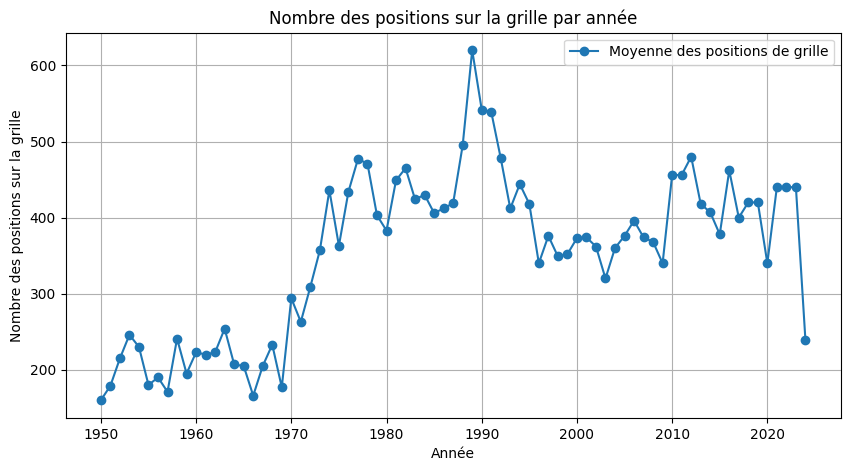

In [30]:
# Graphe 1 : Nombre des positions sur la grille par année
plt.figure(figsize=(10, 5))
plt.plot(grid_count_by_year.index, grid_count_by_year["grid"], marker='o', label="Moyenne des positions de grille")
plt.title("Nombre des positions sur la grille par année")
plt.xlabel("Année")
plt.ylabel("Nombre des positions sur la grille")
plt.grid(True)
plt.legend()
plt.show()

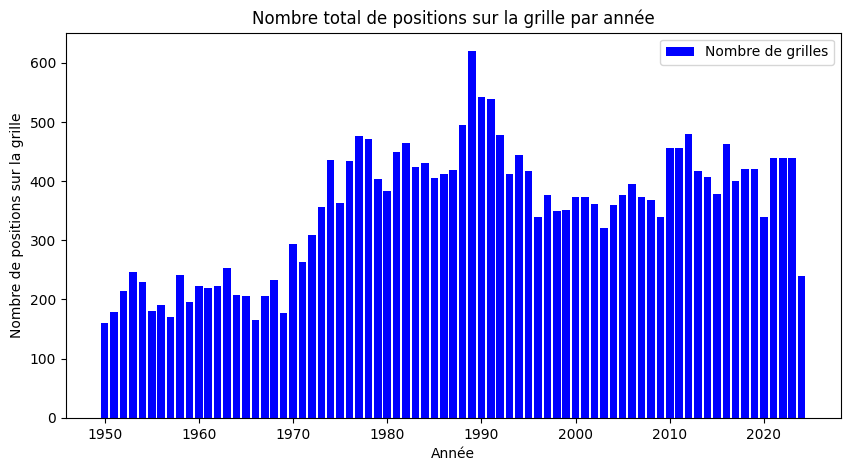

In [31]:
# Graphe 2 : Nombre de positions sur la grille par année
plt.figure(figsize=(10, 5))
plt.bar(grid_count_by_year.index, grid_count_by_year["grid"], color='blue', label="Nombre de grilles")
plt.title("Nombre total de positions sur la grille par année")
plt.xlabel("Année")
plt.ylabel("Nombre de positions sur la grille")
plt.legend()
plt.show()

grid  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
year                                                                           
1950   0   7   7   7   8   7   8   8   7   8   8   7   7   7   6   7   7   7   
1951   0   9   8   9   8   8   9  10   8   8   8   8   8   8   7   7   7   7   
1952  12   9   9   8   9   8   9   8   7   7   8   8  10   8   7   8  10   9   
1953   0  11  10   9   9   9  11  12   9  10  13   9  10  10  10   9  10   8   
1954   3   9   8  10  12  12   8   9  12   9  12  10   9  11   9   8   9   8   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
2020   5  17  17  17  17  17  17  17  17  17  17  17  17  17  17  17  16  17   
2021  12  22  22  22  22  22  22  21  22  22  22  21  22  21  21  21  22  22   
2022  11  22  22  22  22  22  22  22  21  22  21  22  22  21  22  22  22  22   
2023  18  22  21  22  22  22  22  22  22  22  22  22  22  22  22  22  22  21   
2024   4  12  12  12  12  12  12  12  12

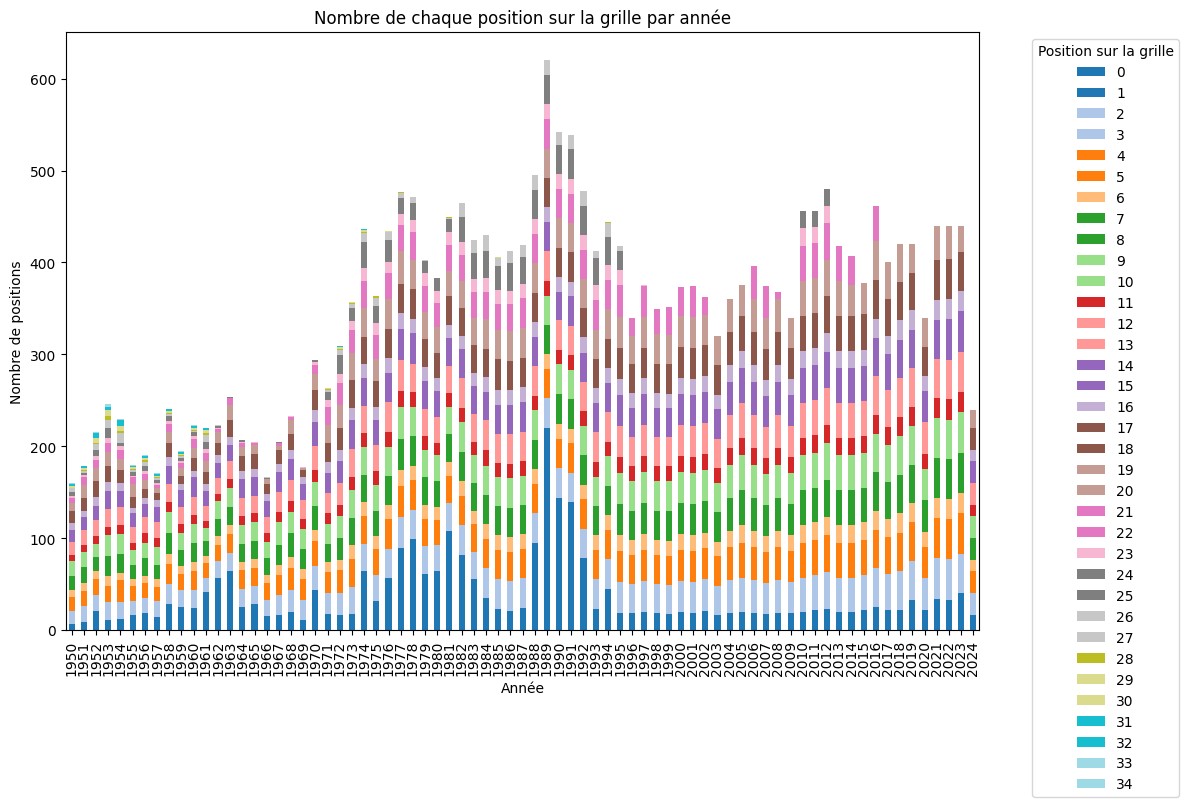

In [32]:
# Comptage des positions sur la grille par année
grid_counts = results_races.groupby(['year', 'grid']).size().unstack(fill_value=0)

# Affichage du tableau
print(grid_counts)

# Création d'un graphique en barres empilées pour visualiser les données
grid_counts.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='tab20')
plt.title('Nombre de chaque position sur la grille par année')
plt.xlabel('Année')
plt.ylabel('Nombre de positions')
plt.legend(title='Position sur la grille', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


+ **`positionOrder`** (fichier `results.csv`) : Position finale à l’arrivée, pour évaluer les progrès ou les déclins des pilotes pendant la course.  

In [33]:
pos_count_by_year = results_races.groupby("year")[["grid"]].count()


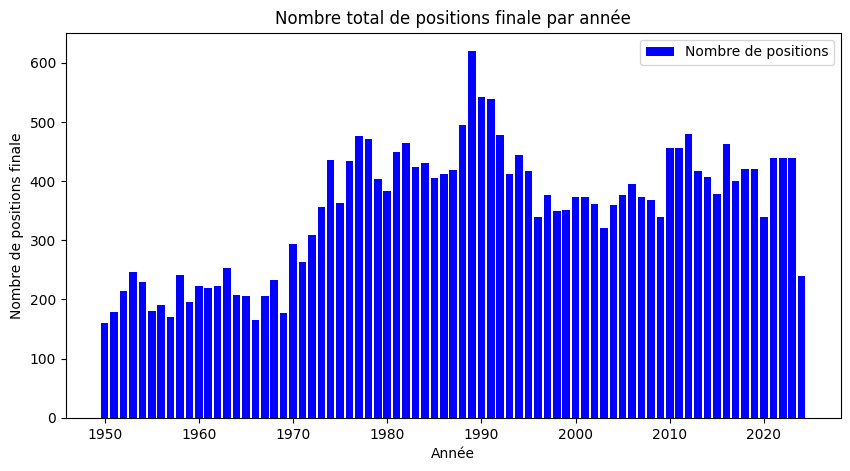

In [34]:
# Graphe 2 : Nombre de positions sur la grille par année
plt.figure(figsize=(10, 5))
plt.bar(pos_count_by_year.index, pos_count_by_year["grid"], color='blue', label="Nombre de positions")
plt.title("Nombre total de positions finale par année")
plt.xlabel("Année")
plt.ylabel("Nombre de positions finale")
plt.legend()
plt.show()

positionOrder  1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
year                                                                            
1950            7   8   7   7   9   8   7   7   7   8   7   7   8   7   6   6   
1951            9   9  10   8   8   8   8   8   8   8   9   8   8   7   7   7   
1952            8   8   8   8   8   8   8   8   9   9   9   8   8   8   9   8   
1953            9   9  11  11   9   9  12  10  11   9   9  11   9   9  11  11   
1954            9  10  10  11   9   9   9  10   9   9  14  10   9   9  11   8   
...            ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
2020           17  17  17  17  17  17  17  17  17  17  17  17  17  17  17  17   
2021           22  22  22  22  22  22  22  22  22  22  22  22  22  22  22  22   
2022           22  22  22  22  22  22  22  22  22  22  22  22  22  22  22  22   
2023           22  22  22  22  22  22  22  22  22  22  22  22  22  22  22  22   
2024           12  12  12  1

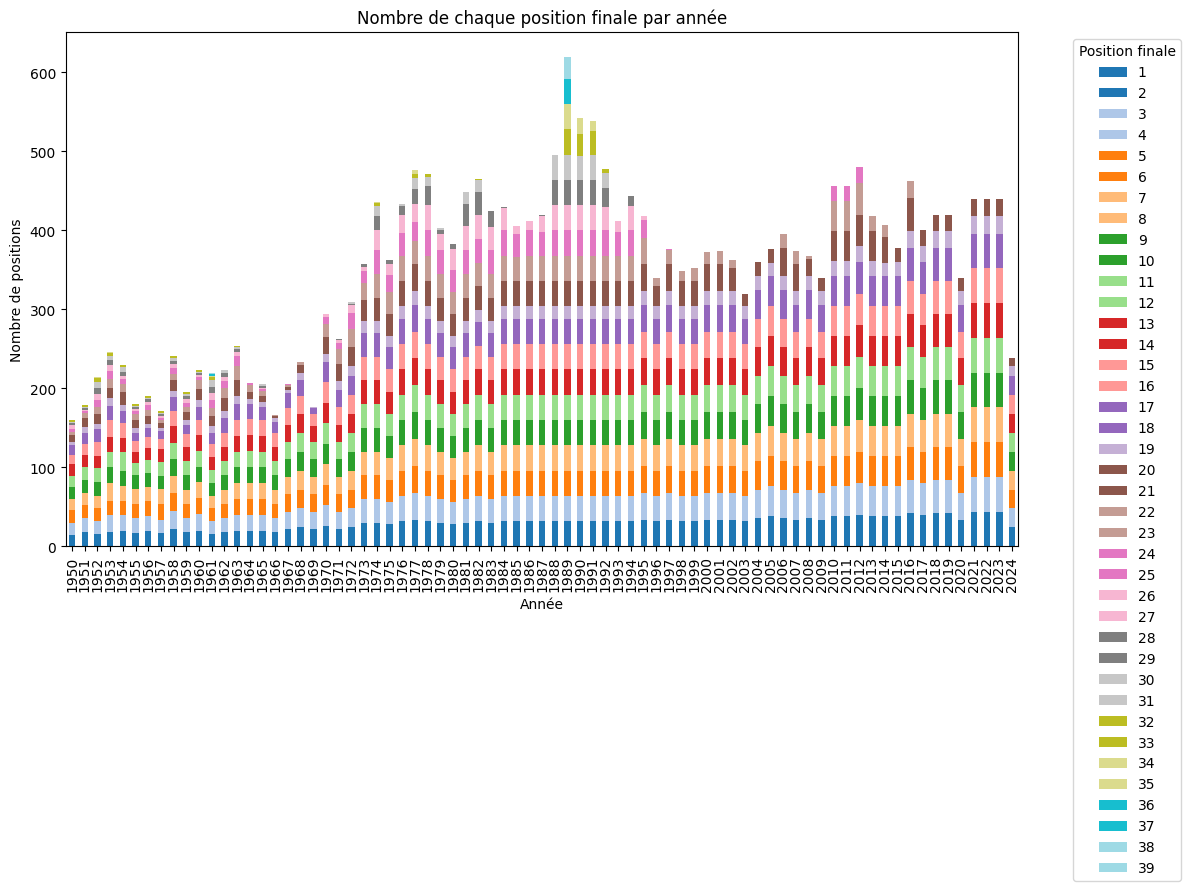

In [35]:
# Comptage des positions sur la grille par année
pos_counts = results_races.groupby(['year', 'positionOrder']).size().unstack(fill_value=0)

# Affichage du tableau
print(pos_counts)

# Création d'un graphique en barres empilées pour visualiser les données
pos_counts.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='tab20')
plt.title('Nombre de chaque position finale par année')
plt.xlabel('Année')
plt.ylabel('Nombre de positions')
plt.legend(title='Position finale', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


+ **`points`** (fichier `driver_standings.csv`) : Points cumulés par pilote, pour relier les performances individuelles à l’évolution globale du championnat.  

C:\Users\atsou\AppData\Local\Temp\ipykernel_19744\3506472584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  points_by_positions = results.groupby(['grid', 'positionOrder'])['points'].sum().reset_index()


     Position Départ (grid)  Position Finale (positionOrder)  Total Points
0                         0                                1           0.0
1                         0                                2           0.0
2                         0                                3           0.0
3                         0                                4           0.0
4                         0                                5          31.0
...                     ...                              ...           ...
1360                     34                               35           0.0
1361                     34                               36           0.0
1362                     34                               37           0.0
1363                     34                               38           0.0
1364                     34                               39           0.0

[1365 rows x 3 columns]


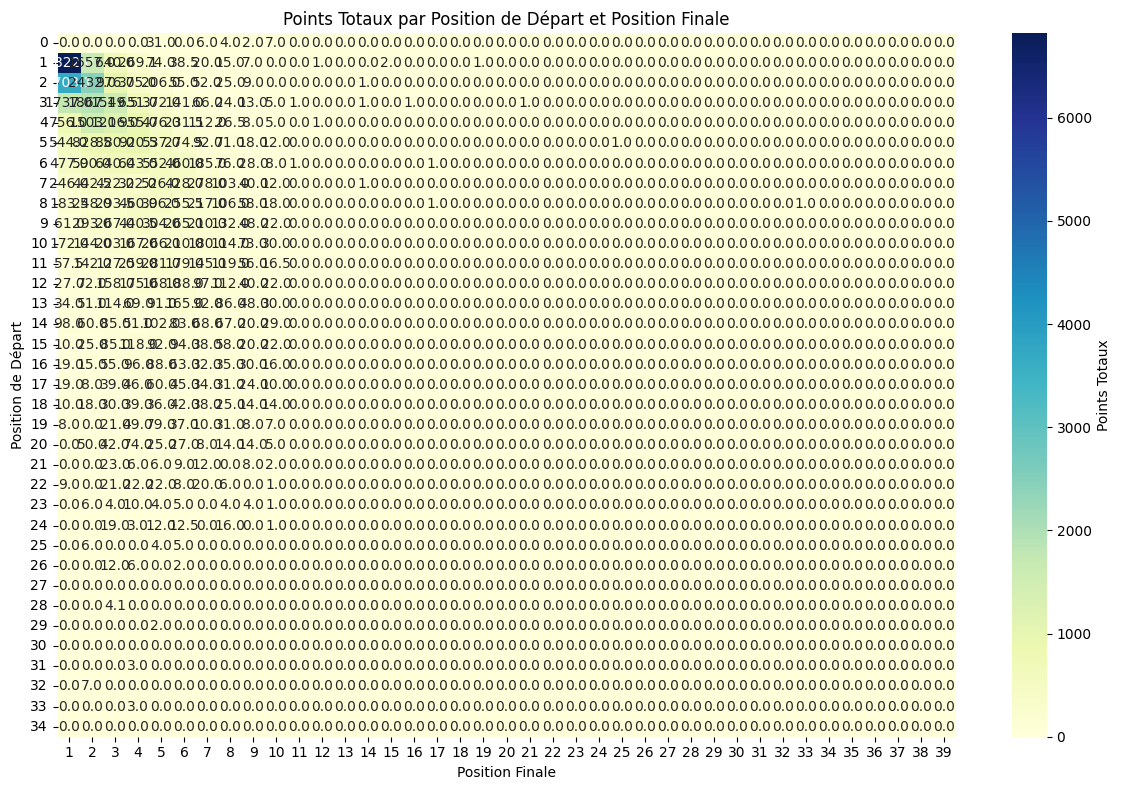

In [36]:
# Calcul des points totaux pour chaque combinaison de position de départ et finale
points_by_positions = results.groupby(['grid', 'positionOrder'])['points'].sum().reset_index()

# Renommer les colonnes pour plus de clarté
points_by_positions.columns = ['Position Départ (grid)', 'Position Finale (positionOrder)', 'Total Points']

# Affichage des résultats
print(points_by_positions)

# Création d'un tableau croisé dynamique pour visualisation
pivot_table = points_by_positions.pivot(index='Position Départ (grid)', columns='Position Finale (positionOrder)', values='Total Points')

# Afficher sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='YlGnBu', cbar_kws={'label': 'Points Totaux'})
plt.title('Points Totaux par Position de Départ et Position Finale')
plt.xlabel('Position Finale')
plt.ylabel('Position de Départ')
plt.tight_layout()
plt.show()


C:\Users\atsou\AppData\Local\Temp\ipykernel_19744\1776968588.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  points_by_positions = results.groupby(['grid', 'positionOrder'])['points'].sum().reset_index()


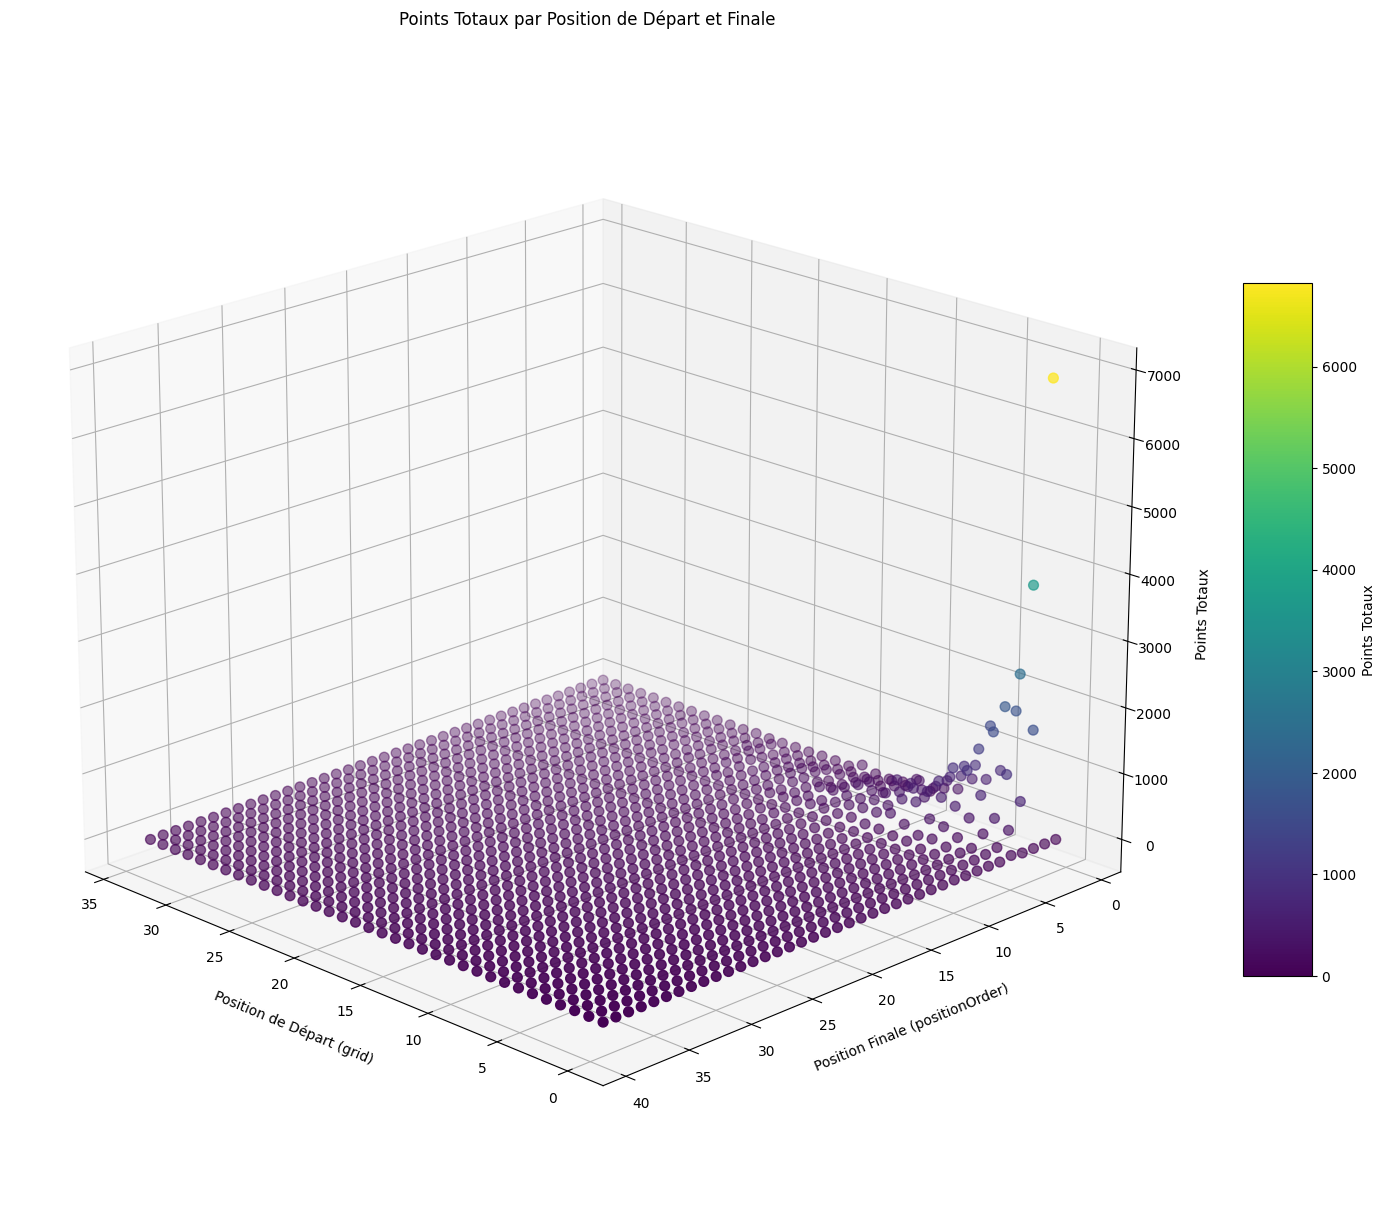

In [40]:


# Préparation des données groupées
points_by_positions = results.groupby(['grid', 'positionOrder'])['points'].sum().reset_index()

# Extraction des valeurs pour les axes
x = points_by_positions['grid']                # Position de départ
y = points_by_positions['positionOrder']       # Position finale
z = points_by_positions['points']             # Points totaux

# Création du graphique 3D
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Tracé des points en 3D
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', s=50)

# Ajout de la barre de couleur
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Points Totaux')

# Configuration des axes
ax.set_title('Points Totaux par Position de Départ et Finale', pad=20)
ax.set_xlabel('Position de Départ (grid)', labelpad=10)
ax.set_ylabel('Position Finale (positionOrder)', labelpad=10)
ax.set_zlabel('Points Totaux', labelpad=10)

# Rotation pour une meilleure vue
ax.view_init(elev=20, azim=135)

# Affichage
plt.show()


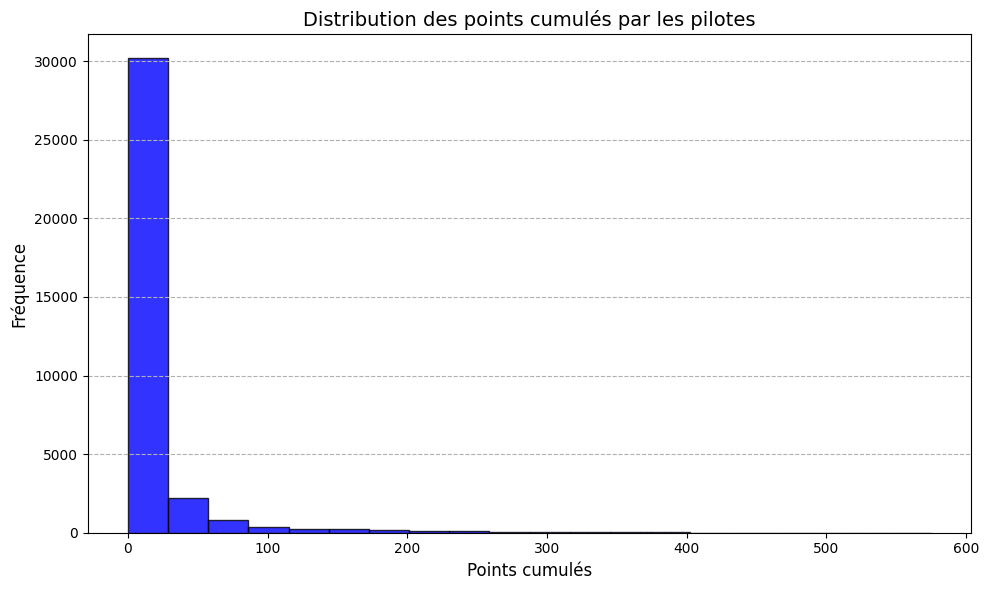

In [38]:
# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(driver_standings['points'], bins=20, color='blue', edgecolor='black', alpha=0.8)

# Personnalisation
plt.title("Distribution des points cumulés par les pilotes", fontsize=14)
plt.xlabel("Points cumulés", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

+ **`milliseconds`** (fichier `lap_times.csv`) : Temps au tour en millisecondes, pour analyser la constance des pilotes et détecter les variations de performance.  